In [1]:
1+1

2

(321, 481)


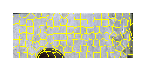

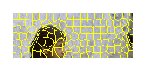

[[  0   0   0 ...,  17  17  17]
 [  0   0   0 ...,  17  17  17]
 [  0   0   0 ...,  17  17  17]
 ..., 
 [112 112 112 ...,  92  92  92]
 [112 112 112 ...,  92  92  92]
 [112 112 112 ...,  92  92  92]]
[[  0   0   0 ...,  17  17  17]
 [  0   0   0 ...,  17  17  17]
 [  0   0   0 ...,  17  17  17]
 ..., 
 [117 117 117 ..., 111 111 111]
 [117 117 117 ..., 111 111 111]
 [117 117 117 ..., 111 111 111]]
[[  0   0   0 ...,  20  20  20]
 [  0   0   0 ...,  20  20  20]
 [  0   0   0 ...,  20  20  20]
 ..., 
 [111 111 111 ..., 123 123 123]
 [111 111 111 ..., 123 123 123]
 [111 111 111 ..., 123 123 123]]
[[  0   0   0 ...,  19  19  19]
 [  0   0   0 ...,  19  19  19]
 [  0   0   0 ...,  19  19  19]
 ..., 
 [104 104 104 ..., 118 118 118]
 [104 104 104 ..., 118 118 118]
 [104 104 104 ..., 118 118 118]]
[[  0   0   0 ...,  17  17  17]
 [  0   0   0 ...,  17  17  17]
 [  0   0   0 ...,  17  17  17]
 ..., 
 [109 109 109 ..., 119 119 119]
 [109 109 109 ..., 119 119 119]
 [109 109 109 ..., 119 119 119]]


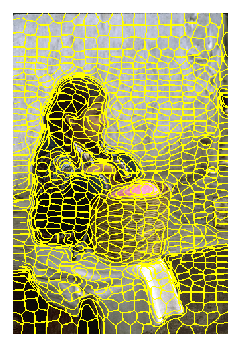

network_ in_time : 1.07007074356
network_ in_time : 1.10639882088
network_ in_time : 1.07748961449
network_ in_time : 1.07338809967
network_ in_time : 1.10989189148
network_ in_time : 0.98131942749
network_ in_time : 1.06305909157
network_ out_time : 0.363164663315
network_ out_time : 0.326836585999
network_ out_time : 0.355745792389
network_ out_time : 0.359847307205
network_ out_time : 0.323343515396
network_ out_time : 0.451915979385
network_ out_time : 0.370176315308
slave node time
             node              time
10   node 6 start 1586486234.598627
12   node 7 start 1586486234.680367
0    node 1 start 1586486234.687379
6    node 4 start 1586486234.690696
4    node 3 start 1586486234.694798
2    node 2 start 1586486234.723707
8    node 5 start 1586486234.727200
11  node 6 finish 1586486234.730121
1   node 1 finish 1586486234.845534
7   node 4 finish 1586486234.919440
13  node 7 finish 1586486234.924865
5   node 3 finish 1586486234.946353
9   node 5 finish 1586486234.970017
3   

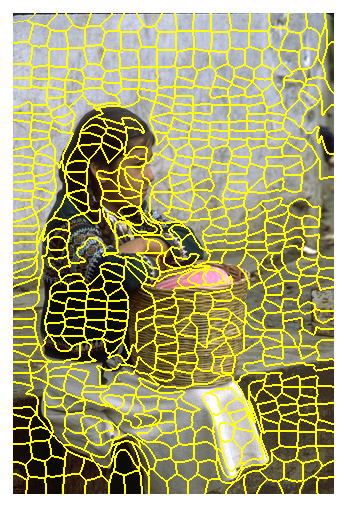

In [1]:
# USAGE
# MR-SLIC_original
from pyspark.context import SparkContext
from skimage.segmentation import mark_boundaries
from skimage import io
import collections as coll
import time
from scipy import ndimage as ndi
from skimage.segmentation import slic
from PIL import Image
from skimage.util import img_as_float
import numpy as np
from skimage.segmentation._slic_master import _slic_cythonM
from skimage.segmentation._slic import _enforce_label_connectivity_cython
from skimage.color import rgb2lab
import os

#number of overlap(0~6)
overlap = 1
#목표 세그먼트
OriginSegments = 500



path = "/home/gangmin/experiment/data/images/train"
file_list = os.listdir(path)
file_list_img = [file for file in file_list if file.endswith(".jpg")]

#split size
split = 8
# 폴더는 overlap+1
#number of partition
partition = split - overlap
# 이미지 조각당 세그먼트 수 
numSegments = (OriginSegments//8)*(overlap+1)

for img_name in file_list_img:
    
    name = img_name[:-4]
    
    #원본 이미지 메타데이터(결과 출력용)
    images = Image.open(path+'/'+img_name)
    #원본 이미지 크기
    (img_w,img_h) = images.size
    print(images.size)
    depth = 1
    #file list
    k=[]
    for i in range(partition):
        k.append(name+'_'+str(i))
    
    
    #ilist 생성
    size = images.size
    temp = size[1]//split
    remain = size[1]%split
    split_list =[]
    for i in range(split):
        split_list.insert(0,temp)
        if remain is not 0:
            split_list[0] = split_list[0]+1
            remain -=1
    index = 0
    listi = []
    for i in range(partition):
        listi.append(index)
        index += split_list[i]
        
    
    
    
    #이미지를 float으로 변환
    images = img_as_float(images)
    #map 함수
    def Map(k):
        #time check
        start_time = time.time()


        #read imagez
        #submit image with job 
        img = Image.open('/home/gangmin/experiment/data/overlap_images/'+str(overlap)+'/'+ k +'.jpg')

        image = img_as_float(img)
        #슬레이브 노드로 작업 분배
        #각 노드에서 이미지 읽고 작업
        segments,distances = slic(image, n_segments = numSegments, sigma = 5)
        #segments(lable(nesre_segments))데이터와 distance 데이터를 둘다 받는다.


        finish_time = time.time()
        #k 로 1,2,3 숫자 받는다.
        return segments, distances, start_time, finish_time, k[-1]
    #times, segments, distances 를 리턴받는다.
    stime = time.time()
    datas = sc.parallelize(k,partition).map(Map).collect()
    
    ftime = time.time()
    
    
    
    
    
    #샘플1
    iimg = Image.open('/home/gangmin/experiment/data/overlap_images/'+str(overlap)+'/'+str(23025)+ '_0' +'.jpg')
    (iimg_w, iimg_h) = iimg.size
    import matplotlib.pyplot as plt
    #save result
    fig = plt.figure("Superpixels -- %d segments" % (OriginSegments),dpi = 96,figsize = (iimg_h/96,iimg_w/96))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(iimg, datas[0][0]))
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)

    #plt.savefig('/home/gangmin/image-resource/result.png',bbox_inces='tight',pad_inches=0)

    plt.axis("off")

    # show the plots
    plt.show()
    #샘플2 
    iimg = Image.open('/home/gangmin/experiment/data/overlap_images/'+str(overlap)+'/'+str(23025)+ '_1' +'.jpg')
    (iimg_w, iimg_h) = iimg.size
    import matplotlib.pyplot as plt
    #save result
    fig = plt.figure("Superpixels -- %d segments" % (OriginSegments),dpi = 96,figsize = (iimg_h/96,iimg_w/96))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(iimg, datas[1][0]))
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)

    #plt.savefig('/home/gangmin/image-resource/result.png',bbox_inces='tight',pad_inches=0)

    plt.axis("off")

    # show the plots
    plt.show()
    
    
    

    #원본 이미지 메타데이터로 dimension 전송
    dimension = [depth,img_h,img_w]
    dimension = np.ascontiguousarray(dimension)

    #segments, distances 리스트 만들기
    indlist = [[],[]]
    tempindex = 0
    for i in datas:
        
        indlist[0] += [int(i[4])+1]
        indlist[1].append(i[0][np.newaxis,:][0].shape[0])
        
        if tempindex is 0:
            seg_array = i[0][np.newaxis,:][0]
            dist_array = i[1][0]
        else:
            seg_array = np.r_[seg_array,i[0][np.newaxis,:][0]]
            dist_array = np.r_[dist_array,i[1][0]]
        print(i[0])
        tempindex +=1
    # array broadcast 불가 -> 합쳐서 전송하고 다시 분리    
    # 분리할때 인덱스대로 분리하고 겉에 []를 씌워줘서 3차원 형태로 만들어야함
    #바뀐점은 한줄로 펴진 array형태로 전달하고, indlist에서 한차원 늘어남.
    
    
    print(indlist)
    print(listi)
    
    result = _slic_cythonM(dist_array,seg_array,np.ascontiguousarray(indlist),dimension,np.ascontiguousarray(listi))

    
    
    
    
    
    
    
    print('@@@')
    print(len(result[0]))
    
    #샘플3
    import matplotlib.pyplot as plt
    #save result
    fig = plt.figure("Superpixels -- %d segments" % (OriginSegments),dpi = 96,figsize = (img_h/96,img_w/96))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(images, result[0]))
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)

    #plt.savefig('/home/gangmin/image-resource/result.png',bbox_inces='tight',pad_inches=0)

    plt.axis("off")

    # show the plots
    plt.show()
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    #label 결속 처리
    if 1:
        segment_size = depth * img_h * img_w / OriginSegments
        min_size = int(0.5 * segment_size)
        max_size = int(3 * segment_size)
        labels = _enforce_label_connectivity_cython(result,min_size,max_size)
    fftime = time.time()

    #time check
    import pandas as pd
    data = pd.DataFrame(columns=['node','time'])
    number = 0
    node = 1
    datat = pd.DataFrame(columns=['node','time'])
    pd.options.display.float_format = '{:.6f}'.format
    for i in datas:
        datat.loc[number]=['node '+str(node),i[3]-i[2]]

        data.loc[number]=['node '+str(node)+' start',i[2]]
        number += 1
        data.loc[number]=['node '+str(node)+' finish',i[3]]
        number += 1
        node+=1

    #network time
    for i in range(0,partition*2,2):
        print('network_ in_time : '+str(data['time'][i]-stime))
    for i in range(0,partition*2,2):
        print('network_ out_time : '+str(ftime-data['time'][i]))


    data = data.sort_values(by=['time'], axis=0)

    #print
    #slave time
    print('slave node time')
    print(data)

    print(datat)

    #reduce time
    print('master_time : '+str(fftime-ftime))

    #whole time
    print('whole_time : '+str(fftime-stime))




    import matplotlib.pyplot as plt
    #save result
    fig = plt.figure("Superpixels -- %d segments" % (OriginSegments),dpi = 96,figsize = (img_w/96,img_h/96))
    ax = fig.add_subplot(1, 1, 1)




    ax.imshow(mark_boundaries(images, labels[0]))
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)

    #plt.savefig('/home/gangmin/image-resource/result.png',bbox_inces='tight',pad_inches=0)

    plt.axis("off")

    # show the plots
    plt.show()
    break

